In [115]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score


Find vairables using ML models. Use them with other columns to find sustainability score. Higher score means better location

Sustainability score for data center = x(Environmental impact)+y(Renewable profile)+z(Infrastructure proximity)

Environmental impact = carbon intensity + Water intensity = $\frac{\text{CO_2e emission}}{\text{Net generation(MWh)}}$ + Water Intensity

Renewable profile = contribution of renewable energy = $\frac{\text{total PCA generation from renewable energy}}{\text{total PCA generation}}$

Infrastructure proximity = Grid stability + fiber distance


In [2]:
df_sheets = pd.read_excel("Input data.xlsx", sheet_name=None)

In [3]:
df_sheet1 = df_sheets["TOC"]
print(df_sheet1)

  List of tables                                         Unnamed: 1
0            NaN                                                NaN
1        Table 1  Scalled energy use by data center type from th...
2        Table 2  Water and carbon intensity of power plants in ...
3        Table 3  Inter PCA electricity transfers to match elect...
4        Table 4            Spatial join of subbasins with the PCAs
5        Table 5          Characterization factors of the subbasins
6        Table 6  Scalled energy use by data centers from the US...


Dataframe for Carbon Emisisons

In [4]:
df1 = df_sheets['Table 1']
df1.columns = ['PCA Name', 'Internal Data Centers Scaled power Consumption 2018 (MWh)', 'Colocation data center Scaled Power Consumption 2018 (MWh)', 'Hyperscale data center Scaled Power Consumption 2018 (MWh)', 'Total Scaled Power Consumption (MWh)']
df1 = df1[3:].reset_index(drop=True)
df1

,PCA Name,Internal Data Centers Scaled power Consumption 2018 (MWh),Colocation data center Scaled Power Consumption 2018 (MWh),Hyperscale data center Scaled Power Consumption 2018 (MWh),Total Scaled Power Consumption (MWh)
0,"Alcoa Power Generating, Inc. - Yadkin Division",923.350417,278.208552,283.613404,1485.172374
1,Anchorage Municipal Light & Power,34519.008414,0,0,34519.008414
2,Arizona Public Service Company,29418.7276,86543.621606,88089.328184,204051.677389
3,"Arlington Valley, LLC - AVBA",3173.747194,10430.744529,10617.092661,24221.584384
4,"Associated Electric Cooperative, Inc.",33689.491674,6205.711663,6316.120266,46211.323604
...,...,...,...,...,...
68,Turlock Irrigation District,26044.394227,18487.373539,18817.998147,63349.765913
69,Western Area Power Administration - Desert Sou...,296287.097429,323804.650252,329586.639356,949678.387037
70,Western Area Power Administration - Rocky Moun...,168204.778329,95200.267568,96900.251272,360305.297169
71,Western Area Power Administration UGP West,6137.638283,3190.055527,3247.124693,12574.818504


In [5]:
df2 = df_sheets['Table 2']
df2.columns = df2.iloc[1]
df2 = df2[2:].reset_index(drop=True)
df2

1,Plant state,Plant name,Plant Id,Balancing Authority Name,Balancing Authority Code,PCA Generation (MWh),Latitude,Longitude,Plant primary fuel,Plant primary fuel code,Net generation (MWh),CO2-e Emission (tons),Water intensity (m3/MWh),Carbon intensity (Tons/MWh),Generation Ratio of Power plant,Water Consumption (m3),Subbasin,HUC8,HUC8 ID
0,AL,ABC Coke,56076,"Southern Company Services, Inc. - Trans",SOCO,255414543.497,33.582793,-86.779866,COG,COAL,5290,1552.988,1.847267,0.293571,0.000021,9772.043741,Locust,03160111,3160111
1,AL,Alabama Pine Pulp,54429,"Southern Company Services, Inc. - Trans",SOCO,255414543.497,31.5825,-87.4889,BLQ,BIOMASS,413079.77,10436.106,1.937552,0.025264,0.001617,800363.491644,Lower Alabama,03150204,3150204
2,AL,Alabama River Pulp,10216,"Southern Company Services, Inc. - Trans",SOCO,255414543.497,31.5825,-87.4889,BLQ,BIOMASS,308063.28,12986.077,1.937552,0.042154,0.001206,596888.592313,Lower Alabama,03150204,3150204
3,AL,AMEA Sylacauga Plant,56018,"Southern Company Services, Inc. - Trans",SOCO,255414543.497,33.1661,-86.2825,NG,GAS,34570,22786.699,0.797026,0.659147,0.000135,27553.194096,Lower Coosa,03150107,3150107
4,AL,ANAD Solar Array,60680,"Southern Company Services, Inc. - Trans",SOCO,255414543.497,33.626728,-85.969481,SUN,SOLAR,17168,0,0.0076,0,0.000067,130.4768,Middle Coosa,03150106,3150106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8398,WY,Western Sugar Coop - Torrington,57967,Western Area Power Administration - Rocky Moun...,WACM,45162128.319,42.0469,-104.1863,NG,GAS,6262.32,2141.555,0.797026,0.341975,0.000139,4991.232816,Middle North Platte-Scotts Bluff,10180009,10180009
8399,WY,Wygen I,55479,Western Area Power Administration - Rocky Moun...,WACM,45162128.319,44.2858,-105.3833,SUB,COAL,639452,837289.793,1.847267,1.309386,0.014159,1181238.736213,Upper Belle Fourche,10120201,10120201
8400,WY,Wygen II,56319,Western Area Power Administration - Rocky Moun...,WACM,45162128.319,44.2919,-105.3811,SUB,COAL,769549,989898.885,1.847267,1.286336,0.01704,1421562.663365,Upper Belle Fourche,10120201,10120201
8401,WY,Wygen III,56596,Western Area Power Administration - Rocky Moun...,WACM,45162128.319,44.2919,-105.3806,SUB,COAL,852015,1070965.4,1.847267,1.25698,0.018866,1573899.404232,Upper Belle Fourche,10120201,10120201


In [6]:
df4 = df_sheets['Table 4']
df4.columns = df4.iloc[1]
df4 = df4[2:].reset_index(drop=True)
df4

1,Subbasin,HUC8,Subbasin Area (m2),HUC8 ID,PCA Name
0,Upper St. John,01010001,17222890136.599998,1010001,ISO New England Inc.
1,Upper St. John,01010001,17222890136.599998,1010001,New Brunswick System Operator
2,Allagash,01010002,3198097222.04,1010002,ISO New England Inc.
3,Allagash,01010002,3198097222.04,1010002,New Brunswick System Operator
4,Fish,01010003,2304014818.42,1010003,ISO New England Inc.
...,...,...,...,...,...
2968,Whitewater River,18100201,3886349590.72,18100201,California Independent System Operator
2969,Carrizo Creek,18100202,1818917328.07,18100202,California Independent System Operator
2970,San Felipe Creek,18100203,2390774785.12,18100203,California Independent System Operator
2971,Salton Sea,18100204,10459920945,18100204,Western Area Power Administration - Desert Sou...


In [7]:
df5 = df_sheets['Table 5']
df5.columns = df5.iloc[1]
df5 = df5[2:].reset_index(drop=True)
df5

1,HUC8 ID,Subbasin,Scaled Power Consumption (MWh),Characterization factor
0,1010001,Upper St. John,887.732534,0.240074
1,1010002,Allagash,0,0.334706
2,1010003,Fish,1242.825547,0.311171
3,1010004,Aroostook,1953.011574,0.309205
4,1010005,Meduxnekeag,1597.918561,0.277446
...,...,...,...,...
2094,18100100,Southern Mojave,19117.122316,100
2095,18100201,Whitewater River,42482.494895,20.27964
2096,18100202,Carrizo Creek,10074.259296,46.577097
2097,18100203,San Felipe Creek,5482.21108,31.673298


In [8]:
# PCA demand intensity calculation
df1_2 = pd.merge(df2, df1[['PCA Name', 'Total Scaled Power Consumption (MWh)']],
              left_on='Balancing Authority Name', right_on = "PCA Name", how='left')
df1_2

,Plant state,Plant name,Plant Id,Balancing Authority Name,Balancing Authority Code,PCA Generation (MWh),Latitude,Longitude,Plant primary fuel,Plant primary fuel code,...,CO2-e Emission (tons),Water intensity (m3/MWh),Carbon intensity (Tons/MWh),Generation Ratio of Power plant,Water Consumption (m3),Subbasin,HUC8,HUC8 ID,PCA Name,Total Scaled Power Consumption (MWh)
0,AL,ABC Coke,56076,"Southern Company Services, Inc. - Trans",SOCO,255414543.497,33.582793,-86.779866,COG,COAL,...,1552.988,1.847267,0.293571,0.000021,9772.043741,Locust,03160111,3160111,"Southern Company Services, Inc. - Trans",2594357.769933
1,AL,Alabama Pine Pulp,54429,"Southern Company Services, Inc. - Trans",SOCO,255414543.497,31.5825,-87.4889,BLQ,BIOMASS,...,10436.106,1.937552,0.025264,0.001617,800363.491644,Lower Alabama,03150204,3150204,"Southern Company Services, Inc. - Trans",2594357.769933
2,AL,Alabama River Pulp,10216,"Southern Company Services, Inc. - Trans",SOCO,255414543.497,31.5825,-87.4889,BLQ,BIOMASS,...,12986.077,1.937552,0.042154,0.001206,596888.592313,Lower Alabama,03150204,3150204,"Southern Company Services, Inc. - Trans",2594357.769933
3,AL,AMEA Sylacauga Plant,56018,"Southern Company Services, Inc. - Trans",SOCO,255414543.497,33.1661,-86.2825,NG,GAS,...,22786.699,0.797026,0.659147,0.000135,27553.194096,Lower Coosa,03150107,3150107,"Southern Company Services, Inc. - Trans",2594357.769933
4,AL,ANAD Solar Array,60680,"Southern Company Services, Inc. - Trans",SOCO,255414543.497,33.626728,-85.969481,SUN,SOLAR,...,0,0.0076,0,0.000067,130.4768,Middle Coosa,03150106,3150106,"Southern Company Services, Inc. - Trans",2594357.769933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8398,WY,Western Sugar Coop - Torrington,57967,Western Area Power Administration - Rocky Moun...,WACM,45162128.319,42.0469,-104.1863,NG,GAS,...,2141.555,0.797026,0.341975,0.000139,4991.232816,Middle North Platte-Scotts Bluff,10180009,10180009,Western Area Power Administration - Rocky Moun...,360305.297169
8399,WY,Wygen I,55479,Western Area Power Administration - Rocky Moun...,WACM,45162128.319,44.2858,-105.3833,SUB,COAL,...,837289.793,1.847267,1.309386,0.014159,1181238.736213,Upper Belle Fourche,10120201,10120201,Western Area Power Administration - Rocky Moun...,360305.297169
8400,WY,Wygen II,56319,Western Area Power Administration - Rocky Moun...,WACM,45162128.319,44.2919,-105.3811,SUB,COAL,...,989898.885,1.847267,1.286336,0.01704,1421562.663365,Upper Belle Fourche,10120201,10120201,Western Area Power Administration - Rocky Moun...,360305.297169
8401,WY,Wygen III,56596,Western Area Power Administration - Rocky Moun...,WACM,45162128.319,44.2919,-105.3806,SUB,COAL,...,1070965.4,1.847267,1.25698,0.018866,1573899.404232,Upper Belle Fourche,10120201,10120201,Western Area Power Administration - Rocky Moun...,360305.297169


In [98]:
dfCarbon = df1_2.drop(columns = ['Plant name', 'Plant Id', 'Balancing Authority Name', 'Plant primary fuel', 'Water intensity (m3/MWh)', 'Carbon intensity (Tons/MWh)', 'Subbasin', 'HUC8', 'PCA Name'], axis = 1)
print(dfCarbon)

     Plant state Balancing Authority Code PCA Generation (MWh)   Latitude  \
0             AL                     SOCO        255414543.497  33.582793   
1             AL                     SOCO        255414543.497    31.5825   
2             AL                     SOCO        255414543.497    31.5825   
3             AL                     SOCO        255414543.497    33.1661   
4             AL                     SOCO        255414543.497  33.626728   
...          ...                      ...                  ...        ...   
8398          WY                     WACM         45162128.319    42.0469   
8399          WY                     WACM         45162128.319    44.2858   
8400          WY                     WACM         45162128.319    44.2919   
8401          WY                     WACM         45162128.319    44.2919   
8402          WY                     PACE         59310290.848  44.290128   

       Longitude Plant primary fuel code Net generation (MWh)  \
0     -86.

In [99]:
print(dfCarbon.columns)


Index(['Plant state', 'Balancing Authority Code', 'PCA Generation (MWh)',
       'Latitude', 'Longitude', 'Plant primary fuel code',
       'Net generation (MWh)', 'CO2-e Emission (tons)',
       'Generation Ratio of Power plant', 'Water Consumption (m3)', 'HUC8 ID',
       'Total Scaled Power Consumption (MWh)'],
      dtype='object')


EDA and data pre-processing

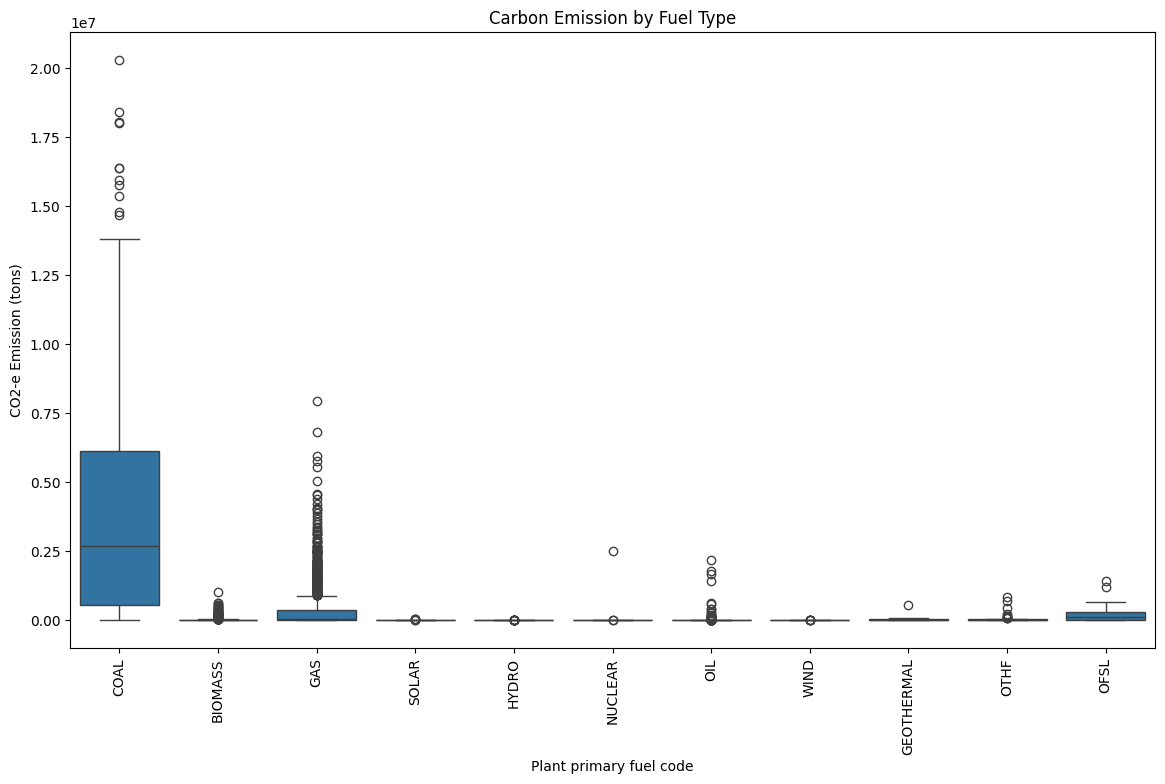

In [100]:
# Explore relationship between fuel type and carbon intensity
plt.figure(figsize=(14, 8))
sns.boxplot(x='Plant primary fuel code', y='CO2-e Emission (tons)', data=df2)
plt.title('Carbon Emission by Fuel Type')
plt.xticks(rotation=90)
plt.show()

In [101]:
# Identify columns with missing values
missing_cols = dfCarbon.columns[dfCarbon.isnull().any()].tolist()
print(f"Columns with missing values: {missing_cols}")
for col in dfCarbon.columns:
    print(f"Column: {col}, Null values: {dfCarbon[col].isnull().sum()}")

Columns with missing values: ['Total Scaled Power Consumption (MWh)']
Column: Plant state, Null values: 0
Column: Balancing Authority Code, Null values: 0
Column: PCA Generation (MWh), Null values: 0
Column: Latitude, Null values: 0
Column: Longitude, Null values: 0
Column: Plant primary fuel code, Null values: 0
Column: Net generation (MWh), Null values: 0
Column: CO2-e Emission (tons), Null values: 0
Column: Generation Ratio of Power plant, Null values: 0
Column: Water Consumption (m3), Null values: 0
Column: HUC8 ID, Null values: 0
Column: Total Scaled Power Consumption (MWh), Null values: 37


In [102]:
for nCol in ['PCA Generation (MWh)', 'Latitude', 'Longitude', 'Net generation (MWh)', 'CO2-e Emission (tons)',
       'Generation Ratio of Power plant', 'Water Consumption (m3)', 'HUC8 ID', 'Total Scaled Power Consumption (MWh)']:
    dfCarbon[nCol] = pd.to_numeric(dfCarbon[nCol], errors="coerce")  # Converts non-numeric values to NaN

# Create imputers for numeric and categorical data
numeric_cols = dfCarbon.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = dfCarbon.select_dtypes(include=['object']).columns
print('Numerical columns: ', numeric_cols)
print('Categorical columns: ', categorical_cols)

# For numeric columns, impute with median
numeric_imputer = SimpleImputer(strategy='mean')
dfCarbon[numeric_cols] = numeric_imputer.fit_transform(dfCarbon[numeric_cols])

# For categorical columns, impute with most frequent value
categorical_imputer = SimpleImputer(strategy='most_frequent')
dfCarbon[categorical_cols] = categorical_imputer.fit_transform(dfCarbon[categorical_cols])

Numerical columns:  Index(['PCA Generation (MWh)', 'Latitude', 'Longitude', 'Net generation (MWh)',
       'CO2-e Emission (tons)', 'Generation Ratio of Power plant',
       'Water Consumption (m3)', 'HUC8 ID',
       'Total Scaled Power Consumption (MWh)'],
      dtype='object')
Categorical columns:  Index(['Plant state', 'Balancing Authority Code', 'Plant primary fuel code'], dtype='object')


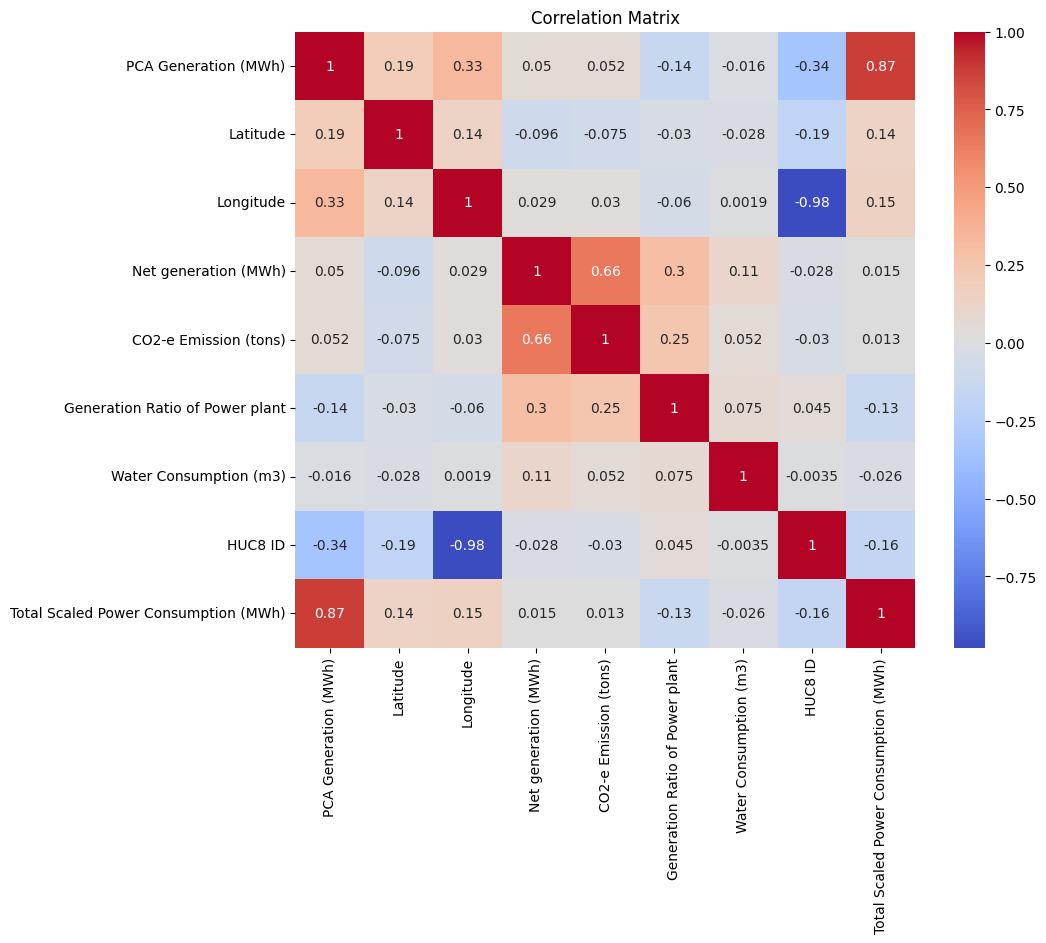

In [114]:

# Correlation matrix for numerical variables
correlation = dfCarbon[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

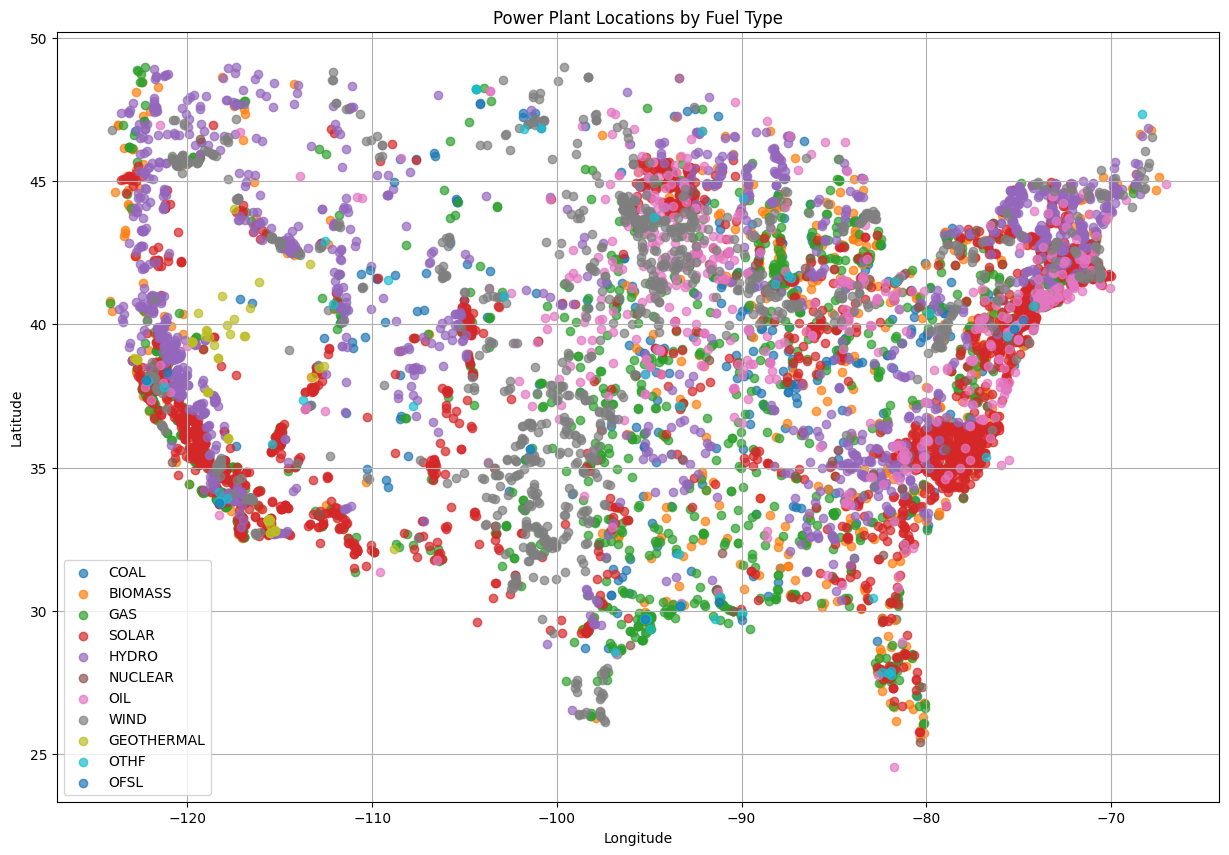

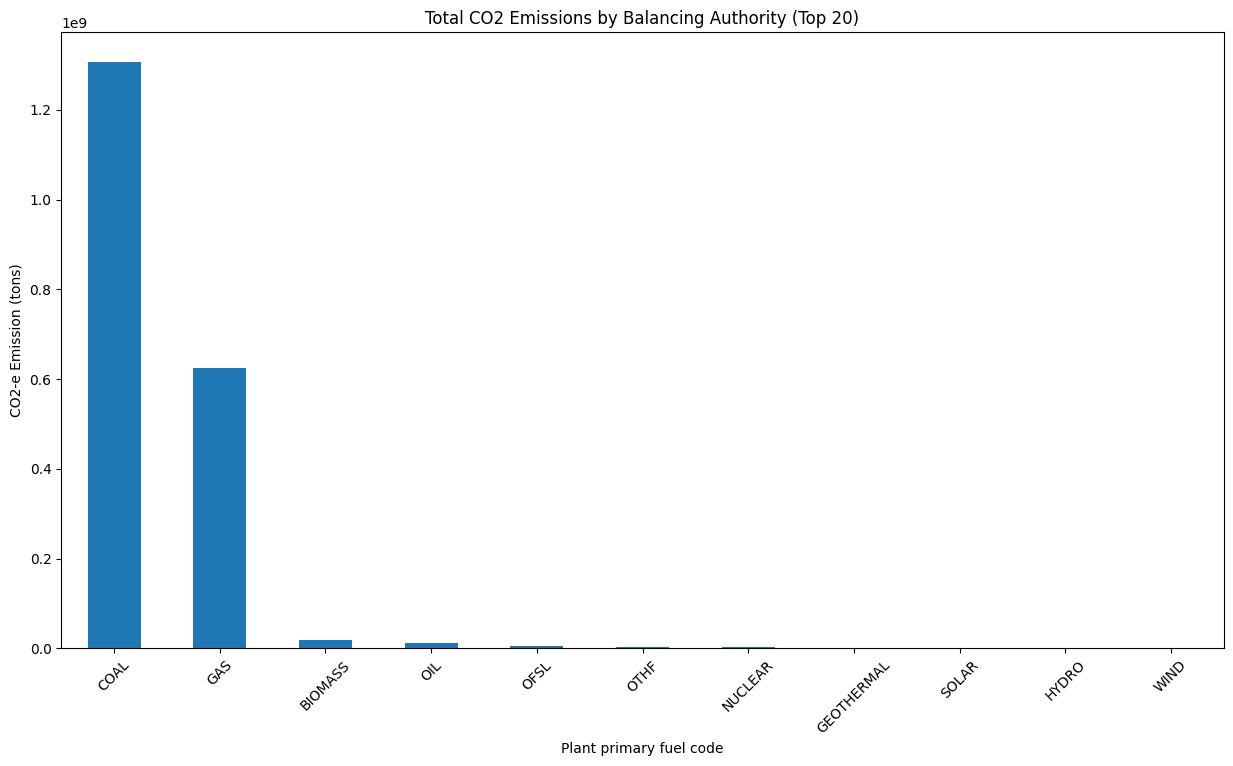

In [104]:
# Plot plant locations colored by fuel type
plt.figure(figsize=(15, 10))
for fuel_type in dfCarbon['Plant primary fuel code'].unique():
    subset = dfCarbon[dfCarbon['Plant primary fuel code'] == fuel_type]
    plt.scatter(subset['Longitude'], subset['Latitude'],
                label=fuel_type, alpha=0.7)
plt.legend()
plt.title('Power Plant Locations by Fuel Type')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

# Emissions by region (using Balancing Authority)
emissions_by_ba = dfCarbon.groupby('Plant primary fuel code')['CO2-e Emission (tons)'].sum().sort_values(ascending=False)
plt.figure(figsize=(15, 8))
emissions_by_ba.head(20).plot(kind='bar')
plt.title('Total CO2 Emissions by Balancing Authority (Top 20)')
plt.ylabel('CO2-e Emission (tons)')
plt.xticks(rotation=45)
plt.show()


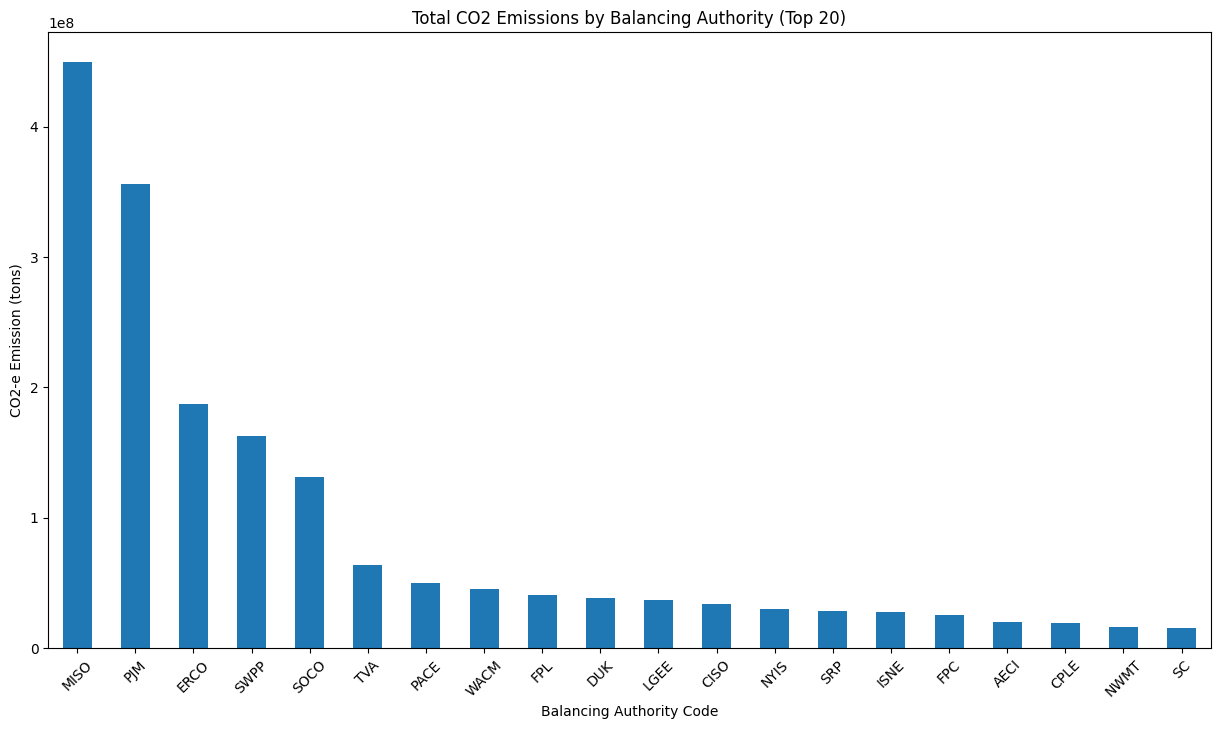

In [105]:
# Emissions by region (using Balancing Authority)
emissions_by_ba = dfCarbon.groupby('Balancing Authority Code')['CO2-e Emission (tons)'].sum().sort_values(ascending=False)
plt.figure(figsize=(15, 8))
emissions_by_ba.head(20).plot(kind='bar')
plt.title('Total CO2 Emissions by Balancing Authority (Top 20)')
plt.ylabel('CO2-e Emission (tons)')
plt.xticks(rotation=45)
plt.show()

In [106]:
# Create renewable energy indicator
renewable_fuels = ['SUN', 'WND', 'WAT', 'HYDRO', 'GEO']
dfCarbon['Is_Renewable'] = dfCarbon['Plant primary fuel code'].isin(renewable_fuels).astype(int)

# Create regional aggregates for emissions
dfCarbon['Regional_Avg_Emission'] = dfCarbon.groupby('Balancing Authority Code')['CO2-e Emission (tons)'].transform('mean')

# Calculate efficiency ratio (output energy vs carbon emissions)
dfCarbon['Efficiency_Ratio'] = dfCarbon['Net generation (MWh)'] / (dfCarbon['CO2-e Emission (tons)'] + 1)  # Adding 1 to avoid division by zero

# Create geographic clusters based on latitude/longitude
geo_features = dfCarbon[['Latitude', 'Longitude']].copy()
kmeans = KMeans(n_clusters=5, random_state=42)
dfCarbon['Geo_Cluster'] = kmeans.fit_predict(geo_features)

# Create fuel type categories (fossil, renewable, nuclear, etc.)
def categorize_fuel(fuel_code):
    if fuel_code in ['COAL', 'GAS', 'OIL']:
        return 'Fossil'
    elif fuel_code in ['SUN', 'WND', 'HYDRO', 'GEO']:
        return 'Renewable'
    elif fuel_code == 'NUCLEAR':
        return 'Nuclear'
    else:
        return 'Other'

dfCarbon['Fuel_Category'] = dfCarbon['Plant primary fuel code'].apply(categorize_fuel)

In [107]:
print(dfCarbon)

     Plant state Balancing Authority Code  PCA Generation (MWh)   Latitude  \
0             AL                     SOCO          2.554145e+08  33.582793   
1             AL                     SOCO          2.554145e+08  31.582500   
2             AL                     SOCO          2.554145e+08  31.582500   
3             AL                     SOCO          2.554145e+08  33.166100   
4             AL                     SOCO          2.554145e+08  33.626728   
...          ...                      ...                   ...        ...   
8398          WY                     WACM          4.516213e+07  42.046900   
8399          WY                     WACM          4.516213e+07  44.285800   
8400          WY                     WACM          4.516213e+07  44.291900   
8401          WY                     WACM          4.516213e+07  44.291900   
8402          WY                     PACE          5.931029e+07  44.290128   

       Longitude Plant primary fuel code  Net generation (MWh) 

In [108]:
catCols = dfCarbon.select_dtypes(include=['object']).columns
dfCarbon = pd.get_dummies(dfCarbon, columns=catCols)

print(dfCarbon)


      PCA Generation (MWh)   Latitude   Longitude  Net generation (MWh)  \
0             2.554145e+08  33.582793  -86.779866               5290.00   
1             2.554145e+08  31.582500  -87.488900             413079.77   
2             2.554145e+08  31.582500  -87.488900             308063.28   
3             2.554145e+08  33.166100  -86.282500              34570.00   
4             2.554145e+08  33.626728  -85.969481              17168.00   
...                    ...        ...         ...                   ...   
8398          4.516213e+07  42.046900 -104.186300               6262.32   
8399          4.516213e+07  44.285800 -105.383300             639452.00   
8400          4.516213e+07  44.291900 -105.381100             769549.00   
8401          4.516213e+07  44.291900 -105.380600             852015.00   
8402          5.931029e+07  44.290128 -105.381482            2251976.00   

      CO2-e Emission (tons)  Generation Ratio of Power plant  \
0                  1552.988        

In [109]:
print(dfCarbon)
print(dfCarbon['Geo_Cluster'].unique())

      PCA Generation (MWh)   Latitude   Longitude  Net generation (MWh)  \
0             2.554145e+08  33.582793  -86.779866               5290.00   
1             2.554145e+08  31.582500  -87.488900             413079.77   
2             2.554145e+08  31.582500  -87.488900             308063.28   
3             2.554145e+08  33.166100  -86.282500              34570.00   
4             2.554145e+08  33.626728  -85.969481              17168.00   
...                    ...        ...         ...                   ...   
8398          4.516213e+07  42.046900 -104.186300               6262.32   
8399          4.516213e+07  44.285800 -105.383300             639452.00   
8400          4.516213e+07  44.291900 -105.381100             769549.00   
8401          4.516213e+07  44.291900 -105.380600             852015.00   
8402          5.931029e+07  44.290128 -105.381482            2251976.00   

      CO2-e Emission (tons)  Generation Ratio of Power plant  \
0                  1552.988        

In [110]:
# Select numerical columns for scaling and normalization
numerical_cols_to_scale = ['PCA Generation (MWh)', 'Latitude', 'Longitude', 'Net generation (MWh)',
                          'CO2-e Emission (tons)', 'Generation Ratio of Power plant',
                          'Water Consumption (m3)', 'Total Scaled Power Consumption (MWh)',
                          'Regional_Avg_Emission', 'Efficiency_Ratio']


# Scaling using MinMaxScaler (scales values between 0 and 1)
scaler = StandardScaler()
dfCarbon[numerical_cols_to_scale] = scaler.fit_transform(dfCarbon[numerical_cols_to_scale])

# Normalization using StandardScaler (scales to zero mean and unit variance)
# scaler = StandardScaler()
# dfCarbon[numerical_cols_to_scale] = scaler.fit_transform(dfCarbon[numerical_cols_to_scale])

dfCarbon


,PCA Generation (MWh),Latitude,Longitude,Net generation (MWh),CO2-e Emission (tons),Generation Ratio of Power plant,Water Consumption (m3),HUC8 ID,Total Scaled Power Consumption (MWh),Is_Renewable,...,Plant primary fuel code_NUCLEAR,Plant primary fuel code_OFSL,Plant primary fuel code_OIL,Plant primary fuel code_OTHF,Plant primary fuel code_SOLAR,Plant primary fuel code_WIND,Fuel_Category_Fossil,Fuel_Category_Nuclear,Fuel_Category_Other,Fuel_Category_Renewable
0,-0.247950,-1.146043,0.392790,-0.264247,-0.196383,-0.152431,-0.073254,3160111.0,-0.643213,0,...,False,False,False,False,False,False,True,False,False,False
1,-0.247950,-1.580714,0.350811,-0.043388,-0.188906,-0.122718,-0.050012,3150204.0,-0.643213,0,...,False,False,False,False,False,False,False,False,True,False
2,-0.247950,-1.580714,0.350811,-0.100265,-0.186759,-0.130370,-0.055994,3150204.0,-0.643213,0,...,False,False,False,False,False,False,False,False,True,False
3,-0.247950,-1.236592,0.422236,-0.248389,-0.178510,-0.150298,-0.072731,3150107.0,-0.643213,0,...,False,False,False,False,False,False,True,False,False,False
4,-0.247950,-1.136495,0.440768,-0.257814,-0.197690,-0.151566,-0.073537,3150106.0,-0.643213,0,...,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8398,-0.955120,0.693240,-0.637757,-0.263720,-0.195887,-0.150236,-0.073395,10180009.0,-0.973561,0,...,False,False,False,False,False,False,True,False,False,False
8399,-0.955120,1.179761,-0.708625,0.079215,0.507072,0.110689,-0.038815,10120201.0,-0.973561,0,...,False,False,False,False,False,False,True,False,False,False
8400,-0.955120,1.181087,-0.708495,0.149675,0.635526,0.164299,-0.031750,10120201.0,-0.973561,0,...,False,False,False,False,False,False,True,False,False,False
8401,-0.955120,1.181087,-0.708465,0.194339,0.703761,0.198282,-0.027272,10120201.0,-0.973561,0,...,False,False,False,False,False,False,True,False,False,False


In [111]:
#  Train test split
y = dfCarbon['CO2-e Emission (tons)']
X = dfCarbon.drop(columns=['CO2-e Emission (tons)'])


# 8. Train-test split with spatial cross-validation to prevent data leak
splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
groups = dfCarbon['HUC8 ID']  # Group by watershed

for train_idx, test_idx in splitter.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [116]:
# Train a simple model to analyze feature importance
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")



Mean Squared Error: 0.0068
R² Score: 0.9924


# Dataframe for Water Intensity

In [ ]:
df2_5 = pd.merge(
    df2,
    df5[['HUC8 ID', 'Characterization factor']],  # Extract relevant columns from Table 5
    on='HUC8 ID',
    how='left'
)

# Step 2: Merge the result with Table 4 using HUC8 ID
df2_5_4 = pd.merge(
    df2_5,
    df4[['HUC8 ID', 'PCA Name']],  # Extract relevant columns from Table 4
    on='HUC8 ID',
    how='left'
)

# Step 3: Merge with Table 1 using PCA Name
df1_2_4_5 = pd.merge(
    df2_5_4,
    df1[['PCA Name', 'Total Scaled Power Consumption (MWh)']],  # Extract relevant columns from Table 1
    on='PCA Name',
    how='left'
)

df1_2_4_5 = df1_2_4_5.loc[df1_2_4_5['Water intensity (m3/MWh)'] > 0]

print(df1_2_4_5)


      Plant state                       Plant name Plant Id  \
0              AL                         ABC Coke    56076   
1              AL                Alabama Pine Pulp    54429   
2              AL               Alabama River Pulp    10216   
3              AL             AMEA Sylacauga Plant    56018   
4              AL             AMEA Sylacauga Plant    56018   
...           ...                              ...      ...   
10948          WY  Western Sugar Coop - Torrington    57967   
10949          WY                          Wygen I    55479   
10950          WY                         Wygen II    56319   
10951          WY                        Wygen III    56596   
10952          WY                           Wyodak     6101   

                                Balancing Authority Name  \
0                Southern Company Services, Inc. - Trans   
1                Southern Company Services, Inc. - Trans   
2                Southern Company Services, Inc. - Trans   
3  

In [ ]:
# Step 4: Select relevant columns for water intensity modeling
columns_to_keep = [
    'Plant state', 'Plant primary fuel code', 'Net generation (MWh)',
    'Water intensity (m3/MWh)', 'Water Consumption (m3)', 'Latitude', 'Longitude',
    'HUC8 ID', 'Characterization factor', 'Total Scaled Power Consumption (MWh)'
]
dfWater = df1_2_4_5[columns_to_keep]

# Display the final merged DataFrame
print(dfWater.columns)

Index(['Plant state', 'Plant primary fuel code', 'Net generation (MWh)',
       'Water intensity (m3/MWh)', 'Water Consumption (m3)', 'Latitude',
       'Longitude', 'HUC8 ID', 'Characterization factor',
       'Total Scaled Power Consumption (MWh)'],
      dtype='object')


In [ ]:
dfWater = dfWater.loc[dfWater['Water intensity (m3/MWh)'] > 0]
print(dfWater)

      Plant state Plant primary fuel code Net generation (MWh)  \
0              AL                    COAL                 5290   
1              AL                 BIOMASS            413079.77   
2              AL                 BIOMASS            308063.28   
3              AL                     GAS                34570   
4              AL                     GAS                34570   
...           ...                     ...                  ...   
10948          WY                     GAS              6262.32   
10949          WY                    COAL               639452   
10950          WY                    COAL               769549   
10951          WY                    COAL               852015   
10952          WY                    COAL              2251976   

      Water intensity (m3/MWh) Water Consumption (m3)   Latitude   Longitude  \
0                     1.847267            9772.043741  33.582793  -86.779866   
1                     1.937552          800363.

Next EDA and pre-processing of data for each.